In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import gc
import torch
import time

from langchain_community.document_loaders import TextLoader, PyPDFLoader
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_experimental.text_splitter import SemanticChunker
from langchain_core.documents import Document
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [2]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})

In [3]:
#loader = PyPDFLoader('./data/투자설명서.pdf')
#docs = loader.load()
#full_text = '\n\n'.join(doc.page_content for doc in docs)
#text_splitter = SemanticChunker(embeddings=embeddings)
#documents = text_splitter.create_documents([full_text])
#for doc in documents:
#    doc.metadata['source'] = '투자설명서.pdf'
#print(len(documents))

In [4]:
gc.collect()
torch.cuda.empty_cache()
time.sleep(3)

In [5]:
text = """
이재용 회장은 삼성전자를 이끌고 있으며, 차세대 반도체 개발에 집중하고 있다.
삼성전자는 대한민국 평택과 미국 테일러시에 반도체 공장을 두고 있다.
SK하이닉스는 곽노정 CEO가 이끌고 있으며, HBM(고대역폭메모리) 시장을 선도하고 있다.
삼성전자와 SK하이닉스는 AI 반도체 시장의 핵심 고객인 엔비디아(NVIDIA)에 HBM을 공급하기 위해 경쟁한다.
엔비디아의 CEO는 젠슨 황이다.
한편, 대만의 TSMC는 파운드리 분야에서 삼성전자의 가장 큰 경쟁사이다.
삼성전자는 갤럭시 스마트폰도 생산한다.
"""

documents = [Document(page_content=text)]

In [6]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_transformer = LLMGraphTransformer(llm=llm)
print(llm_transformer)

In [7]:
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f'노드: {len(graph_documents[0].nodes)}')
print(f'엣지: {len(graph_documents[0].relationships)}')

노드: 14
엣지: 12


In [8]:
G = nx.DiGraph()

for doc in graph_documents:
    for node in doc.nodes:
        G.add_node(node.id, type=node.type)
    for edge in doc.relationships:
        G.add_edge(edge.source.id, edge.target.id, label=edge.type)

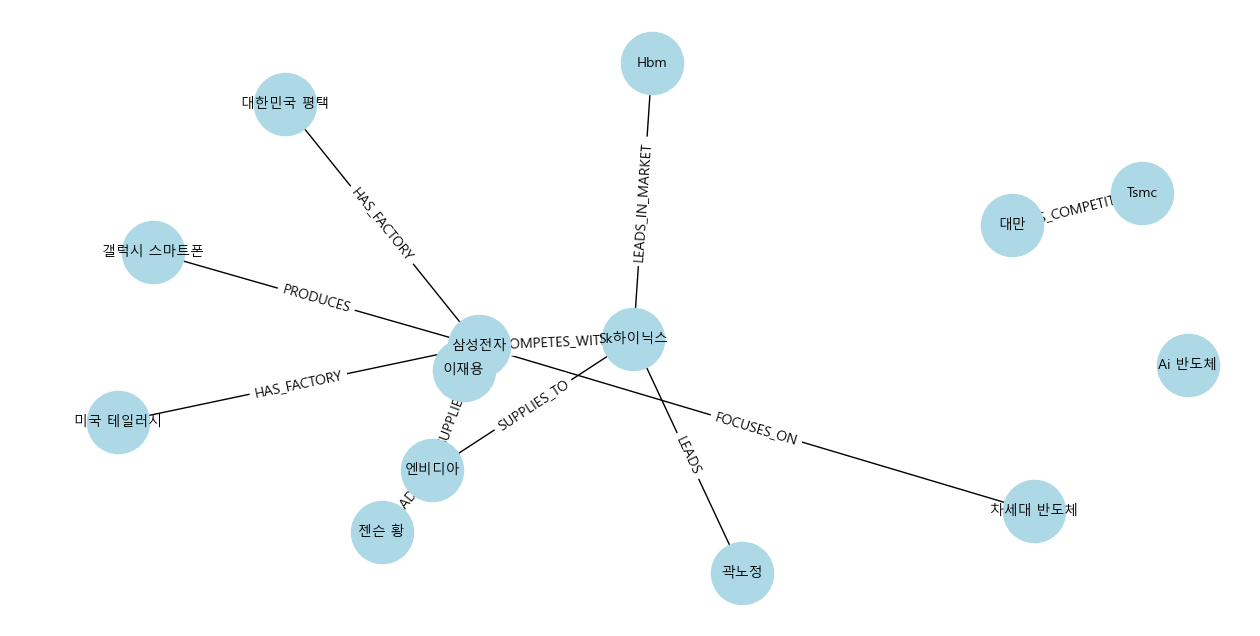

In [11]:
plt.figure(figsize=(16, 8))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_family='Malgun Gothic', font_size=10)

nx.draw_networkx_edges(G, pos, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_family='Malgun Gothic')

plt.axis('off')
plt.show()

In [14]:
query_entity = '삼성전자'
if query_entity in G:
    print(f'\n=== "{query_entity}" 관련 지식 (Graph 검색 결과) ===')
    for neighbor in G.successors(query_entity):
        relation = G[query_entity][neighbor]['label']
        print(f'{query_entity} --[{relation}]--> {neighbor}')
    for predecessor in G.predecessors(query_entity):
        relation = G[predecessor][query_entity]['label']
        print(f'{predecessor} --[{relation}]--> {query_entity}')


=== "삼성전자" 관련 지식 (Graph 검색 결과) ===
삼성전자 --[FOCUSES_ON]--> 차세대 반도체
삼성전자 --[HAS_FACTORY]--> 대한민국 평택
삼성전자 --[HAS_FACTORY]--> 미국 테일러시
삼성전자 --[COMPETES_WITH]--> Sk하이닉스
삼성전자 --[SUPPLIES_TO]--> 엔비디아
삼성전자 --[PRODUCES]--> 갤럭시 스마트폰
이재용 --[LEADS]--> 삼성전자
